In [1]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 6.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.1 MB/s eta 0:00:00


In [2]:
import contractions
print(contractions.fix("I can't do this anymore"))

I cannot do this anymore


In [3]:
import warnings, logging
warnings.filterwarnings("ignore")
logging.getLogger("transformers").setLevel(logging.ERROR)

In [4]:
import pandas as pd
import numpy as np
import random
import re

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from tqdm.auto import tqdm
import logging
logging.getLogger("transformers").setLevel(logging.WARNING)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


2026-01-03 05:09:52.070420: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767416992.269603      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767416992.327375      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767416992.808513      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767416992.808570      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767416992.808573      55 computation_placer.cc:177] computation placer alr

device: cuda


In [5]:
import os, random, logging, warnings
import numpy as np
import torch

logging.getLogger("transformers").setLevel(logging.CRITICAL)
warnings.filterwarnings('ignore')

DATA_PATH = "/kaggle/input/thefinal-dataset/thefinal_dataset.csv"  
TEXT_COLUMN = 'text_clean'
LABEL_COLUMN = 'status'

TEST_SIZE = 0.2
VALIDATION_SPLIT_SIZE = 0.1

MODEL_NAME_DL = 'roberta-base'
MAX_LEN_DL = 160
BATCH_SIZE_DL = 16
EPOCHS_DL = 3
LEARNING_RATE_DL = 2e-5
WEIGHT_DECAY_DL = 0.01
PATIENCE_EPOCHS = 1

MIN_WORDS_AFTER_CLEANING = 5
SEED = 42

OUTPUT_DIR = "/kaggle/working/models/roberta_v1"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True

set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [6]:
# =========================
# 0) Install (Kaggle GPU)
# =========================
!pip -q install -U transformers accelerate evaluate

import os, json, random, warnings, logging, inspect
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

from transformers import (
    RobertaTokenizerFast,
    RobertaConfig,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

warnings.filterwarnings("ignore")
logging.getLogger("transformers").setLevel(logging.WARNING)

# =========================
# 1) Config
# =========================
SEED = 42
DATA_PATH = "/kaggle/input/thefinal-dataset/thefinal_dataset.csv"
LABEL_COLUMN = "status"
TEXT_CANDIDATES = ["text_clean", "text"]

OUTPUT_DIR = "/kaggle/working/roberta_gpu_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

MODEL_NAME_DL = "roberta-base"
MAX_LEN_DL = 160

TEST_SIZE = 0.2
VALIDATION_SPLIT_SIZE = 0.1

# Anti-overfitting (safe defaults)
EPOCHS = 3
LR = 2e-5
WEIGHT_DECAY = 0.01
DROPOUT = 0.2
WARMUP_RATIO = 0.1
EARLY_STOP_PATIENCE = 1

# GPU batch sizes (safe for P100)
BATCH_TRAIN = 16
BATCH_EVAL = 16

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("GPU device:", device)

# =========================
# 2) Load + Clean + Label encode
# =========================
print("\nData Loading...")
df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.strip()

if "Unnamed: 0" in df.columns:
    df = df.drop("Unnamed: 0", axis=1)

# pick text column
TEXT_COLUMN = None
for c in TEXT_CANDIDATES:
    if c in df.columns:
        TEXT_COLUMN = c
        break
if TEXT_COLUMN is None:
    raise KeyError("No text column found. Expected one of: " + str(TEXT_CANDIDATES))

print("Using text column:", TEXT_COLUMN)

df[TEXT_COLUMN] = df[TEXT_COLUMN].astype(str).fillna("")
df = df.dropna(subset=[LABEL_COLUMN]).copy()
df[LABEL_COLUMN] = df[LABEL_COLUMN].astype(str).str.strip().str.lower()

unique_labels = sorted(df[LABEL_COLUMN].unique().tolist())
label2id = {lab: i for i, lab in enumerate(unique_labels)}
id2label = {i: lab for lab, i in label2id.items()}
df["label_id"] = df[LABEL_COLUMN].map(label2id)

num_labels = len(unique_labels)
print(f"Found {num_labels} labels:", unique_labels)

X = df[TEXT_COLUMN]
y = df["label_id"]

# =========================
# 3) Train/Val/Test split (STRATIFIED)
# =========================
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=SEED, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=VALIDATION_SPLIT_SIZE,
    random_state=SEED, stratify=y_train_full
)

print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))

# =========================
# 4) Class weights (IMBALANCE)
# =========================
classes = np.arange(num_labels)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train.values)
class_weights = torch.tensor(weights, dtype=torch.float)

print("Class weights:", class_weights.tolist())

# =========================
# 5) Dataset
# =========================
tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_NAME_DL)

class MentalHealthDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            str(self.texts[idx]),
            truncation=True,
            padding="max_length",
            max_length=self.max_len
        )
        item = {k: torch.tensor(v) for k, v in enc.items()}
        item["labels"] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return item

train_ds = MentalHealthDataset(X_train, y_train, tokenizer, MAX_LEN_DL)
val_ds   = MentalHealthDataset(X_val,   y_val,   tokenizer, MAX_LEN_DL)
test_ds  = MentalHealthDataset(X_test,  y_test,  tokenizer, MAX_LEN_DL)

# =========================
# 6) Model (dropout for anti-overfitting)
# =========================
config = RobertaConfig.from_pretrained(
    MODEL_NAME_DL,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    hidden_dropout_prob=DROPOUT,
    attention_probs_dropout_prob=DROPOUT
)

model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME_DL, config=config)

# =========================
# 7) WeightedTrainer (imbalance fixed here)
# =========================
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        weights = self.class_weights
        if weights is not None:
            weights = weights.to(logits.device)

        loss_fct = nn.CrossEntropyLoss(weight=weights)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

# =========================
# 8) Metrics (macro-F1)
# =========================
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
    }

# =========================
# 9) TrainingArguments (GPU + grad accumulation)
# =========================
sig = inspect.signature(TrainingArguments.__init__).parameters
EVAL_KEY = "evaluation_strategy" if "evaluation_strategy" in sig else "eval_strategy"

training_args_kwargs = dict(
    output_dir=OUTPUT_DIR,
    seed=SEED,

    num_train_epochs=EPOCHS,
    learning_rate=LR,
    per_device_train_batch_size=BATCH_TRAIN,
    per_device_eval_batch_size=BATCH_EVAL,
    gradient_accumulation_steps=2,   
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO,
    lr_scheduler_type="linear",
    max_grad_norm=1.0,

    optim="adamw_torch",

    fp16=True,  # GPU P100

    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    save_total_limit=2,

    logging_steps=100,
    report_to="none",
)

training_args_kwargs[EVAL_KEY] = "epoch"
training_args = TrainingArguments(**training_args_kwargs)

print("Using TrainingArguments eval key:", EVAL_KEY)
print("Optimizer:", training_args.optim)
print("Gradient accumulation:", training_args.gradient_accumulation_steps)

# =========================
# 10) Train (EarlyStopping)
# =========================
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=EARLY_STOP_PATIENCE)]
)

trainer.train()

# =========================
# 11) Test Evaluation
# =========================
pred = trainer.predict(test_ds)
y_pred = np.argmax(pred.predictions, axis=1)

print("\n=== TEST CLASSIFICATION REPORT ===")
print(classification_report(
    y_test, y_pred,
    target_names=[id2label[i] for i in range(num_labels)],
    zero_division=0
))

cm = confusion_matrix(y_test, y_pred, labels=list(range(num_labels)))
print("Confusion matrix shape:", cm.shape)

# =========================
# 12) Export model
# =========================
EXPORT_DIR = os.path.join(OUTPUT_DIR, "roberta_export")
os.makedirs(EXPORT_DIR, exist_ok=True)

trainer.save_model(EXPORT_DIR)
tokenizer.save_pretrained(EXPORT_DIR)

with open(os.path.join(EXPORT_DIR, "label2id.json"), "w", encoding="utf-8") as f:
    json.dump(label2id, f, ensure_ascii=False, indent=2)

with open(os.path.join(EXPORT_DIR, "id2label.json"), "w", encoding="utf-8") as f:
    json.dump({str(k): v for k, v in id2label.items()}, f, ensure_ascii=False, indent=2)

print("\nModel exported to:", EXPORT_DIR)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 115.0 MB/s eta 0:00:0000:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.2 MB/s eta 0:00:00
GPU device: cuda

Data Loading...
Using text column: text
Found 14 labels: ['addiction', 'adhd', 'alcoholism', 'anxiety', 'aspergers', 'bipolar disorder', 'depression', 'normal', 'ocd', 'personality disorder', 'ptsd', 'schizophrenia', 'stress', 'suicidal']
Train: 341567 Val: 37952 Test: 94880
Class weights: [5.164615154266357, 0.5491625070571899, 6.666022777557373, 1.8127381801605225, 2.525374412536621, 0.932204008102417, 0.23487502336502075, 1.1219886541366577, 1.3357592821121216, 2.2880654335021973, 1.5898373126983643, 4.411072731018066, 2.1110706329345703, 0.4648763835430145]


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using TrainingArguments eval key: eval_strategy
Optimizer: OptimizerNames.ADAMW_TORCH
Gradient accumulation: 2


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.548800,0.519971,0.775690,0.795835,0.775943
2,0.450100,0.471594,0.797692,0.824250,0.798055
3,0.341500,0.461241,0.803383,0.830693,0.803887



=== TEST CLASSIFICATION REPORT ===
                      precision    recall  f1-score   support

           addiction       0.76      0.85      0.80      1312
                adhd       0.93      0.90      0.92     12341
          alcoholism       0.77      0.90      0.83      1017
             anxiety       0.91      0.94      0.93      3739
           aspergers       0.68      0.81      0.74      2684
    bipolar disorder       0.80      0.84      0.82      7270
          depression       0.84      0.65      0.74     28854
              normal       0.96      0.97      0.97      6040
                 ocd       0.87      0.89      0.88      5073
personality disorder       0.93      0.95      0.94      2962
                ptsd       0.76      0.85      0.80      4263
       schizophrenia       0.67      0.82      0.74      1536
              stress       0.89      0.95      0.92      3210
            suicidal       0.62      0.81      0.70     14579

            accuracy            

In [18]:
# =========================
# 13) Inference function (Kaggle GPU P100)
# =========================
model.eval()  # important: disable dropout

def predict_text(text: str, top_k: int = 3):
    # tokenize
    enc = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=MAX_LEN_DL
    )

    # move to GPU if available
    enc = {k: v.to(device) for k, v in enc.items()}

    with torch.no_grad():
        logits = model(**enc).logits
        probs = torch.softmax(logits, dim=1).squeeze().detach().cpu().numpy()

    top_idx = probs.argsort()[-top_k:][::-1]
    return [(id2label[int(i)], float(probs[i])) for i in top_idx]

print(predict_text("I can’t focus on anything and my mind keeps jumping from one thought to another.", top_k=3))


[('anxiety', 0.6921132206916809), ('ocd', 0.22601668536663055), ('aspergers', 0.021711356937885284)]


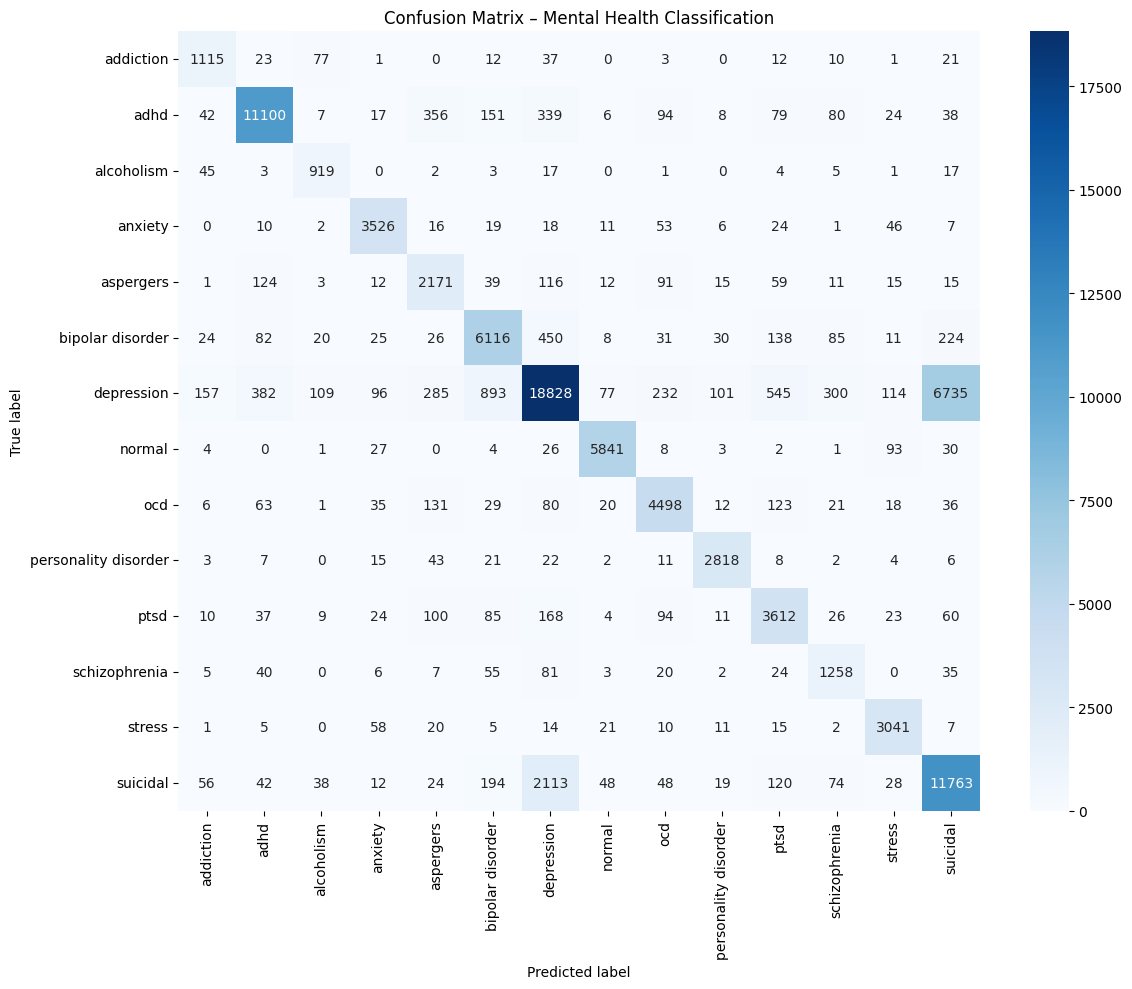

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = [id2label[i] for i in range(len(id2label))]

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    xticklabels=labels,
    yticklabels=labels,
    annot=True,        
    cmap="Blues",
    fmt="d"
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – Mental Health Classification")
plt.tight_layout()
plt.show()


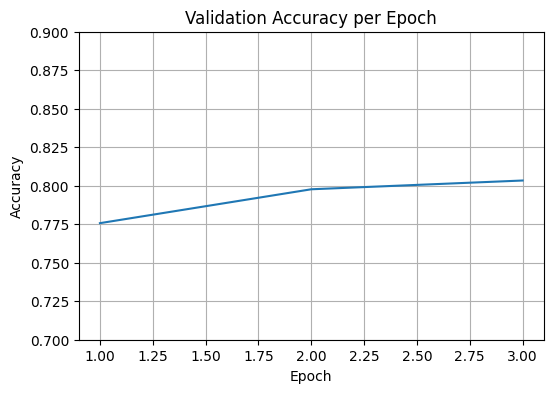

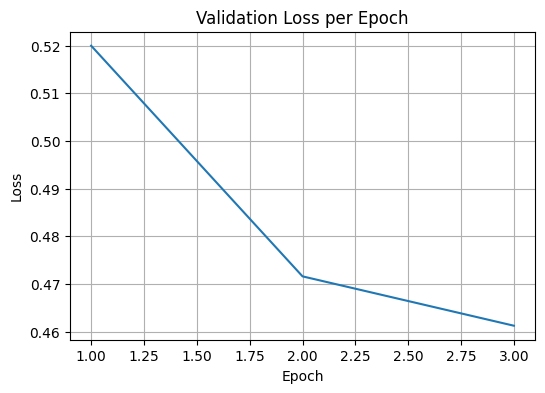

In [36]:
import numpy as np
import matplotlib.pyplot as plt

logs = trainer.state.log_history

# epochs
epochs = []
val_acc = []
val_loss = []

for l in logs:
    if "eval_accuracy" in l and "epoch" in l:
        epochs.append(l["epoch"])
        val_acc.append(l["eval_accuracy"])
        val_loss.append(l["eval_loss"])

# =========================
# COURBE : Validation Accuracy
# =========================
plt.figure(figsize=(6,4))
plt.plot(epochs, val_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy per Epoch")
plt.ylim(0.7, 0.9)   # ajuste si besoin
plt.grid(True)
plt.show()

# =========================
# COURBE : Validation Loss
# =========================
plt.figure(figsize=(6,4))
plt.plot(epochs, val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss per Epoch")
plt.grid(True)
plt.show()


In [41]:
import torch
import torch.nn.functional as F
import json
import numpy as np
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification

# =========================
# CONFIG
# =========================
EXPORT_DIR = "/kaggle/working/roberta_gpu_output/roberta_export"
MAX_LEN = 160
TOP_K = 4

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =========================
# LOAD MODEL + TOKENIZER
# =========================
tokenizer = RobertaTokenizerFast.from_pretrained(EXPORT_DIR)
model = RobertaForSequenceClassification.from_pretrained(EXPORT_DIR)
model.to(DEVICE)
model.eval()

with open(f"{EXPORT_DIR}/id2label.json", "r") as f:
    id2label = {int(k): v for k, v in json.load(f).items()}

# =========================
# PREDICTION FUNCTION
# =========================
def predict(text):
    inputs = tokenizer(
        text,
        truncation=True,
        padding=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    ).to(DEVICE)

    with torch.no_grad():
        logits = model(**inputs).logits
        probs = F.softmax(logits, dim=1)[0].cpu().numpy()

    top_idx = np.argsort(probs)[::-1][:TOP_K]

    print(f"\nTEXT: {text}")
    print(f"PREDICTION: {id2label[top_idx[0]]} ({probs[top_idx[0]]:.3f})")
    print("TOP-4 PREDICTIONS:")
    for i in top_idx:
        print(f"  - {id2label[i]}: {probs[i]:.3f}")

# =========================
# TEST
# =========================
predict("i got my phd")



TEXT: i got my phd
PREDICTION: normal (0.997)
TOP-4 PREDICTIONS:
  - normal: 0.997
  - ocd: 0.000
  - depression: 0.000
  - anxiety: 0.000
